In [1]:
import psydac.core.interface as inter
import numpy as np
import sympy as sym
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import derivatives as der
import projectors as proj
import evaluation as eva
import integrate as integr
import time
import mass_matrices_curved as ma

In [2]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet)
bc = [False, True, True]

bc_x, bc_y, bc_z = bc

# ... length of computational domain in each direction
Lx = 1
Ly = 1
Lz = 1

# ... number of elements in each direction and corresponding element boundaries
Nel_x = 10
Nel_y = 10
Nel_z = 5

dx = Lx/Nel_x
dy = Ly/Nel_y
dz = Lz/Nel_z

el_b_x = np.linspace(0, Lx, Nel_x + 1)
el_b_y = np.linspace(0, Ly, Nel_y + 1)
el_b_z = np.linspace(0, Lz, Nel_z + 1)

# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 3, 3]
px, py, pz = p

# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase

# ... number of degrees of freedom
Nbase_x_0 = Nbase_x - bc_x*px - (1 - bc_x)*2
Nbase_y_0 = Nbase_y - bc_y*py - (1 - bc_y)*2
Nbase_z_0 = Nbase_z - bc_z*pz - (1 - bc_z)*2


# ... knot vectors
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    
if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    
T = [Tx, Ty, Tz]

# ... define mapping
R1 = 0.2
R2 = 1.0
dR = R2 - R1

xc = lambda r, phi, z : (r*dR + R1)*np.cos(2*np.pi*phi)
yc = lambda r, phi, z : (r*dR + R1)*np.sin(2*np.pi*phi)
zc = lambda r, phi, z : z


g = lambda r, phi, z : 2*np.pi*dR*(r*dR + R1)
#g = lambda q1, q2, q3 : 1.

G = [[lambda r, phi, z : dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 4*np.pi**2*(r*dR + R1)**2, lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#G = [[lambda q1, q2, q3 : 1., lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 0.], [lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 1., lambda q1, q2, q3 : 0.], [lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 1.]]

Ginv = [[lambda r, phi, z : 1/dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1/(4*np.pi**2*(r*dR + R1)**2), lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#Ginv = [[lambda q1, q2, q3 : 1., lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 0.], [lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 1., lambda q1, q2, q3 : 0.], [lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 0., lambda q1, q2, q3 : 1.]]

In [3]:
# ... model
phi0 = lambda r, phi, z : r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)
f3 = lambda r, phi, z : -(dR - 4*r*dR - 2*R1)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)/(dR**2*(r*dR + R1)) + 4*r*(1 - r)/(r*dR + R1)**2*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z) + 4*np.pi**2*r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)

f1 = [lambda r, phi, z : 0., lambda r, phi, z : (r*dR + R1)*np.cos(2*np.pi*phi) , lambda r, phi, z : 0.]

In [4]:
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g, bc)
G = der.GRAD_3d(p, Nbase, bc)

In [5]:
#fun = lambda r, phi, z : 1/g(r, phi, z)*f3(r, phi, z)
fun = lambda r, phi, z : f3(r, phi, z)

fint = ma.L2_prod_V0(fun, p, Nbase, T, g, bc)

In [6]:
# ... assemble linear system
Block_01 = M1.dot(G)
Block_10 = G.T.dot(M1)
Block_11 = np.zeros((Block_10.shape[0], Block_01.shape[1]))

RHS = np.append(np.zeros(M1.shape[0]), np.reshape(fint, Nbase_x_0*Nbase_y_0*Nbase_z_0))


K = sparse.bmat([[-M1, Block_01], [Block_10, Block_11]], format='csr')

In [7]:
# ... solve system
res = sparse.linalg.spsolve(K, RHS)
phivec = res[M1.shape[0]:]

(-0.9994965423831851, 1.0, -0.9998741276738751, 0.9998741276738751)

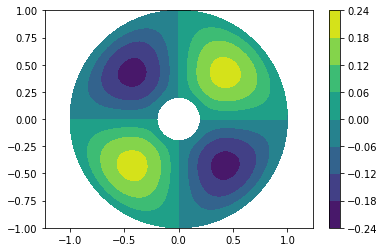

In [8]:
zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing = 'ij')
PHI0 = phi0(R, PHI, zplot)

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

plt.contourf(X, Y, PHI0)
plt.colorbar()
plt.axis('equal')

In [9]:
PHI0.max()

0.2022081568956002

(-0.9994965423831851, 1.0, -0.9998741276738751, 0.9998741276738751)

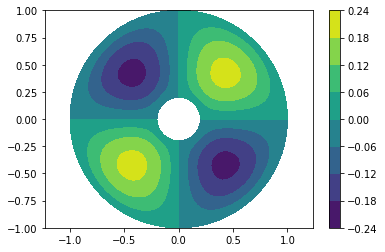

In [10]:
zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing='ij')
PHI0_h = eva.evaluate_field_V0(phivec, [rplot, phiplot, zplot], p, Nbase, T, bc)

PHI0_h = np.reshape(PHI0_h, (100, 100))
X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

plt.contourf(X, Y, PHI0_h)
plt.colorbar()
plt.axis('equal')

In [11]:
PHI0_h.max()

0.20120108538287787

In [12]:
M0 = ma.mass_matrix_V0(p, Nbase, T, g, bc)

In [13]:
fint = ma.L2_prod_V0(phi0, p, Nbase, T, g, bc)

In [15]:
# ... solve system
res = sparse.linalg.spsolve(M0, fint)

(-0.9994965423831851, 1.0, -0.9998741276738751, 0.9998741276738751)

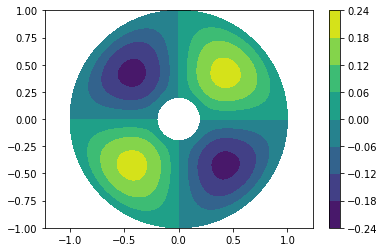

In [16]:
zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing='ij')
PHI0_h = eva.evaluate_field_V0(res, [rplot, phiplot, zplot], p, Nbase, T, bc)

PHI0_h = np.reshape(PHI0_h, (100, 100))
X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

plt.contourf(X, Y, PHI0_h)
plt.colorbar()
plt.axis('equal')

In [17]:
PHI0_h.max()

0.2012409785885172

In [4]:
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g, [None, True, None])
CURL = der.CURL_3d(p, Nbase, bc)

In [5]:
fint = ma.L2_prod_V1(f1, p, Nbase, T, Ginv, g, [None, True, None])

In [6]:
res = sparse.linalg.spsolve(M1, fint)
exvec = res[:960]
eyvec = res[960:2000]

(-1.095245518701739,
 1.0997735961286543,
 -1.0987540731013088,
 1.0987540731013088)

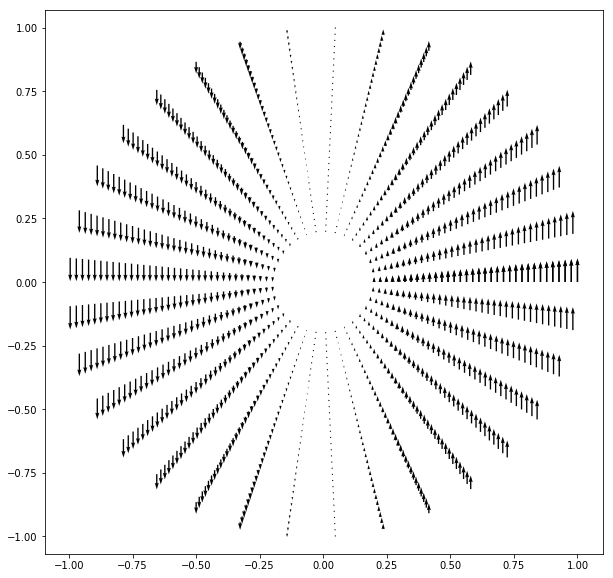

In [7]:
zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing='ij')

Ex = f1[0](R, PHI, zplot)
Ey = f1[1](R, PHI, zplot)

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

s = 3
plt.quiver(X[::s, ::s], Y[::s, ::s], Ex, Ey[::s, ::s])



plt.axis('equal')

(-1.095245518701739,
 1.0997735961286543,
 -1.0987540731013088,
 1.0987540731013088)

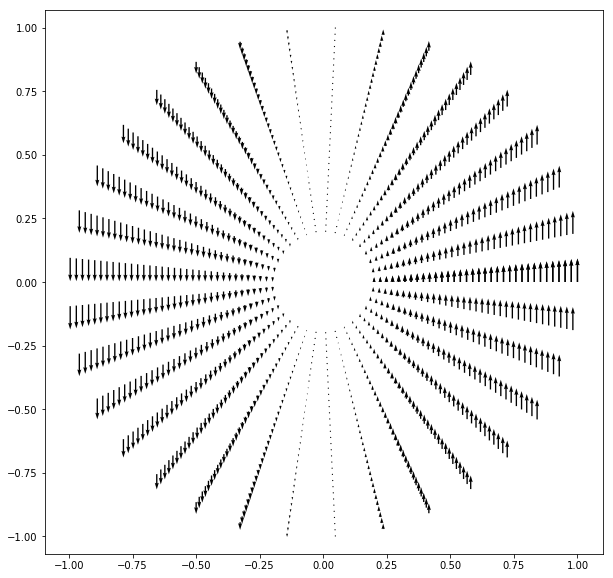

In [11]:
zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing='ij')

Exh = eva.evaluate_field_V1_x(exvec, [rplot, phiplot, zplot], p, Nbase, T, [None, True, None])
Eyh = eva.evaluate_field_V1_y(eyvec, [rplot, phiplot, zplot], p, Nbase, T, [None, True, None])

Exh = np.reshape(Exh, (100, 100))
Eyh = np.reshape(Eyh, (100, 100))

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

s = 3
plt.quiver(X[::s, ::s], Y[::s, ::s], Exh[::s, ::s], Eyh[::s, ::s])



plt.axis('equal')